This notebook serves to continue the work on the parity check grokking effect, trying to find what increases the gap between the increase in training accuracy and then test accuracy.

In particular, this notebook looks into the effect of only considering the final values after a set of training runs. It isn't perfect by any means, but havving good data on how different classes of training runs wind up tending should be useful.

In particular, this enables better data visualisation. More sophisticated plots should also be made, but not necessarily for publication. Rather, only for viewing by the user of this software to ensure that the results obtained make any sense.

In [4]:
import numpy as np
import secrets
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
#import matplotlib.animation as animation
#from matplotlib import style
import seaborn as sns
import time

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import torch.nn.functional as F

100%|██████████| 100/100 [02:33<00:00,  1.54s/it]


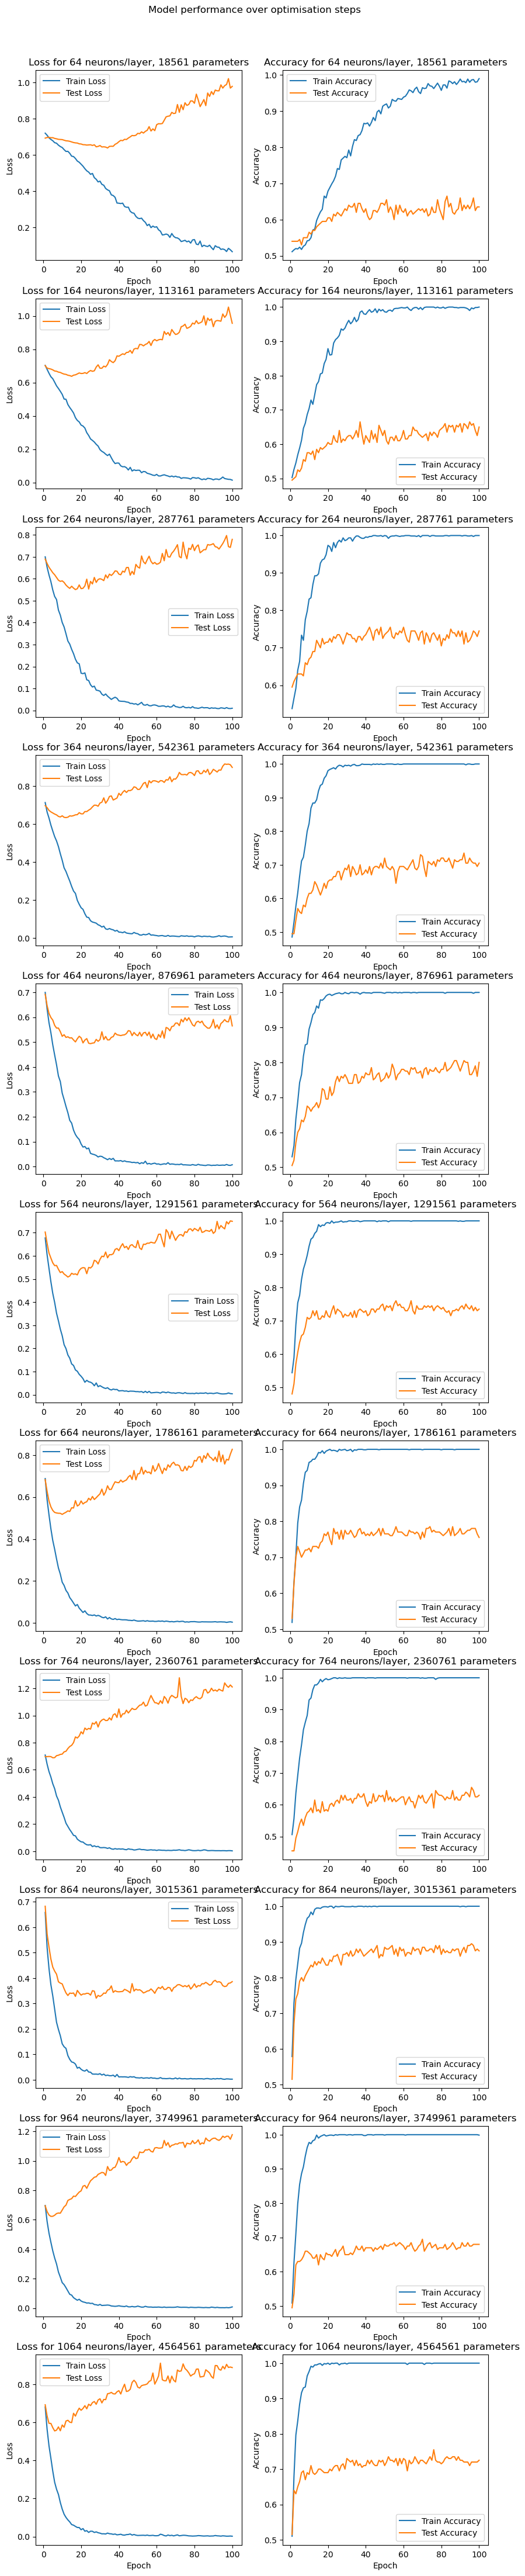

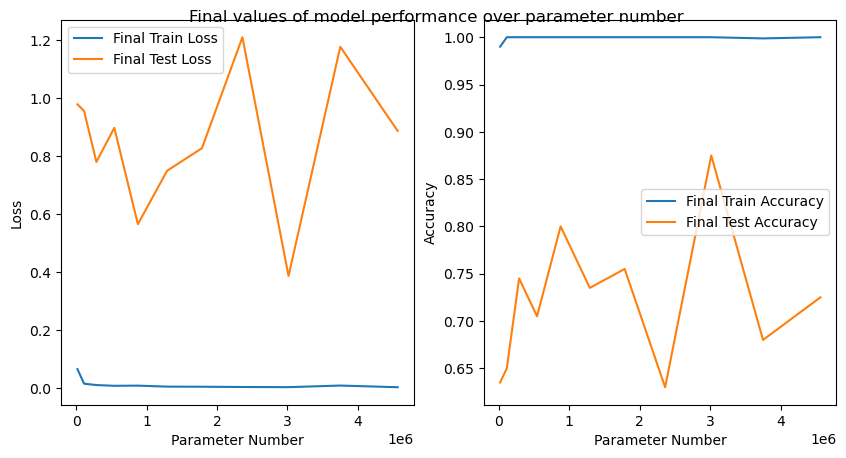

In [2]:
# hidden_size_list. Change the number of neurons in the hidden layer. Use n_tasks=6 and n_layers = 6 each time I think
# n_layers might be a bit too big, as I seemed to get pretty solid performance with n_layers = 4.

n_tasks = 6 # number of tasks created. must be less than or equal to 2^len_taskcode.
len_taskcode = 8 # length of the code defining the task. This will go at the beginning of each entry
num_checks = 3  # Length of the associated integer list for each task. Must be less than len_message
len_message = 12  # Maximum integer value in the associated integer list
num_samples = 1000 # number of samples created in the dataset
#samples_per_task = 1 # Kept at 1 for as long as I do not actually want to check the task performance
# Define hyperparameters
input_size = len_taskcode + len_message
output_size = 1
learning_rate = 0.005
batch_size = 32
num_epochs = 100
test_frac = 0.2
num_layers = 6
#hidden_size_list = np.logspace(start=0, stop=9, num=10, endpoint=True, base=2, dtype=int) 
#[   1    2    4    8   16   32   64  128  256  512 1024]
hidden_size_list = np.arange(64, 1065, 100) #64 seems to be the smallest value which converges after about 100 epochs

def generate_random_binary_string(length):
    binary_string = ''.join(secrets.choice(['0', '1']) for _ in range(length))
    return binary_string

def generate_dict(n_tasks, len_taskcode, num_checks, len_message):
    unique_strings = set()
    tasks_dict = {}

    while len(unique_strings) < n_tasks:
        binary_string = generate_random_binary_string(len_taskcode)

        if binary_string not in unique_strings:
            unique_strings.add(binary_string)

            integer_list = [secrets.randbelow(len_message) for _ in range(num_checks)]
            tasks_dict[binary_string] = integer_list

    return tasks_dict

def generate_dataset(tasks_dict, num_samples):
  data = np.zeros((num_samples, len_taskcode + len_message))
  value = np.zeros(num_samples)
  for i in range(num_samples):
    rand_task = np.random.choice(list(tasks_dict))
    rand_checkbits = tasks_dict[rand_task]
    message = generate_random_binary_string(len_message)
    parity_bit = 0
    for j in rand_checkbits:
      parity_bit += int(message[j])
    parity = parity_bit % 2
    data[i] = np.concatenate((np.array(list(rand_task)), np.array(list(message))))
    value[i] = parity
  return [data, value]

# Define a NN class WITH BATCH NORMALISATION
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, output_size, num_layers, hidden_size):
        super(NeuralNetwork, self).__init__()

        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(input_size, hidden_size))  # Additional linear layer
        
        for _ in range(num_layers - 2):
            self.layers.append(nn.Linear(hidden_size, hidden_size))
            self.layers.append(nn.BatchNorm1d(hidden_size))  # Add BatchNorm1d layer
        
        self.layers.append(nn.Linear(hidden_size, output_size))
    
    def forward(self, x):
        for i, layer in enumerate(self.layers[:-1]):
            if i == 0:  # Apply ReLU activation only after the additional linear layer
                x = F.relu(layer(x))
            else:
                x = layer(x)
                if i % 2 == 0:
                    x = F.relu(x)  # Apply ReLU activation after each linear layer
        x = self.layers[-1](x)
        return x

# Define a custom dataset
class CustomDataset(Dataset):
    def __init__(self, dataframe):
        self.data = dataframe.iloc[:, :-1].values
        self.target = dataframe.iloc[:, -1].values
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        x = torch.from_numpy(self.data[idx]).float()
        y = torch.tensor(self.target[idx]).float()
        return x, y
    
    
final_train_loss = np.empty(len(hidden_size_list))
final_test_loss = np.empty(len(hidden_size_list))
final_train_accuracy = np.empty(len(hidden_size_list))
final_test_accuracy = np.empty(len(hidden_size_list))
parameter_list = np.empty(len(hidden_size_list))
    
#plt.close()
fig, axs = plt.subplots(len(hidden_size_list), 2, figsize=(10, len(hidden_size_list)*5))
for index, hidden_size in enumerate(hidden_size_list):
    
    tasks_dict = generate_dict(n_tasks, len_taskcode, num_checks, len_message)

    [data, value] = generate_dataset(tasks_dict, num_samples)

    # Create a dataframe for training
    df = pd.DataFrame(np.concatenate((data, value.reshape(-1, 1)), axis=1), columns=[f'feature_{i}' for i in range(len_taskcode + len_message)] + ['target'])

    # Split the data into training and test sets
    #train_df, test_df = train_test_split(df, test_size=test_frac, random_state=42)
    train_df, test_df = train_test_split(df, test_size=test_frac, random_state=42)

    # Create instances of the neural network
    model = NeuralNetwork(input_size, output_size, num_layers, hidden_size)

    # Define loss function and optimizer (same as before)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)

    # Create DataLoaders for the training and test data
    train_dataset = CustomDataset(train_df)
    test_dataset = CustomDataset(test_df)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    train_loss_list = np.empty(num_epochs)
    test_loss_list = np.empty(num_epochs)

    train_accuracy_list = np.empty(num_epochs)
    test_accuracy_list = np.empty(num_epochs)

    accuracy_array = np.zeros((n_tasks, num_epochs)) # such that each row is the accuracy for that specific task over all epochs

    # Train the model
    for epoch in tqdm(range(num_epochs)):
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        model.train()

        for inputs, labels in train_loader:
            # Forward pass
            outputs = model(inputs)

            # Compute loss
            loss = criterion(outputs, labels.unsqueeze(1))

            # Compute predictions
            predictions = (outputs >= 0.5).squeeze().long()

            # Compute accuracy
            train_correct += (predictions == labels).sum().item()
            train_total += labels.size(0)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)

        # Calculate average train loss
        train_loss = train_loss / len(train_dataset)
        # Calculate average train accuracy
        train_accuracy = train_correct / train_total

        # Evaluate the model on the test set
        model.eval()
        test_loss = 0.0
        test_correct = 0
        test_total = 0

        with torch.no_grad():
            for inputs, labels in test_loader:
                outputs = model(inputs)
                # Compute predictions
                predictions = (outputs >= 0.5).squeeze().long()

                # Compute accuracy
                test_correct += (predictions == labels).sum().item()
                test_total += labels.size(0)

                loss = criterion(outputs, labels.unsqueeze(1))
                test_loss += loss.item() * inputs.size(0)

            # Calculate average test loss
            test_loss = test_loss / len(test_dataset)

        # Calculate average test accuracy
        test_accuracy = test_correct / test_total

        # Update the loss lists
        train_loss_list[epoch] = train_loss
        test_loss_list[epoch] = test_loss

        train_accuracy_list[epoch] = train_accuracy
        test_accuracy_list[epoch] = test_accuracy


    # Create subplots with 1 row and 2 columns
    #fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    
    pytorch_total_params = sum(p.numel() for p in model.parameters())
    #print(f"Total model parameters = {pytorch_total_params}")

    # Plot the training and test losses on the first subplot
    axs[index,0].plot(range(1, num_epochs+1), train_loss_list, label='Train Loss')
    axs[index,0].plot(range(1, num_epochs+1), test_loss_list, label='Test Loss')
    axs[index,0].set_xlabel('Epoch')
    axs[index,0].set_ylabel('Loss')
    axs[index,0].legend()
    axs[index, 0].set_title(f'Loss for {hidden_size} neurons/layer, {pytorch_total_params} parameters')  # Set title for the first subplot

    # Plot the training and test accuracies on the second subplot
    axs[index,1].plot(range(1, num_epochs+1), train_accuracy_list, label='Train Accuracy')
    axs[index,1].plot(range(1, num_epochs+1), test_accuracy_list, label='Test Accuracy')
    axs[index,1].set_xlabel('Epoch')
    axs[index,1].set_ylabel('Accuracy')
    axs[index,1].legend()
    axs[index,1].set_title(f'Accuracy for {hidden_size} neurons/layer, {pytorch_total_params} parameters')
    
    final_train_loss[index] = train_loss_list[-1]
    final_test_loss[index] = test_loss_list[-1]
    final_train_accuracy[index] = train_accuracy_list[-1]
    final_test_accuracy[index] = test_accuracy_list[-1]
    parameter_list[index] = pytorch_total_params

# Adjust the spacing between subplots
#plt.tight_layout()
plt.suptitle('Model performance over optimisation steps', y=0.88) #y=0.9 seems about right for spacing here
# Show the subplots
plt.show()

plt.close()

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].plot(parameter_list, final_train_loss, label='Final Train Loss')
axs[0].plot(parameter_list, final_test_loss, label='Final Test Loss')
axs[0].set_xlabel('Parameter Number')
axs[0].set_ylabel('Loss')
axs[0].legend()
# title

axs[1].plot(parameter_list, final_train_accuracy, label='Final Train Accuracy')
axs[1].plot(parameter_list, final_test_accuracy, label='Final Test Accuracy')
axs[1].set_xlabel('Parameter Number')
axs[1].set_ylabel('Accuracy')
axs[1].legend()

plt.suptitle('Final values of model performance over parameter number', y=0.92)
plt.show()

C:\Users\plogo\anaconda3\envs\cnn\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\plogo\anaconda3\envs\cnn\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\plogo\anaconda3\envs\cnn\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\plogo\anaconda3\envs\cnn\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Conver

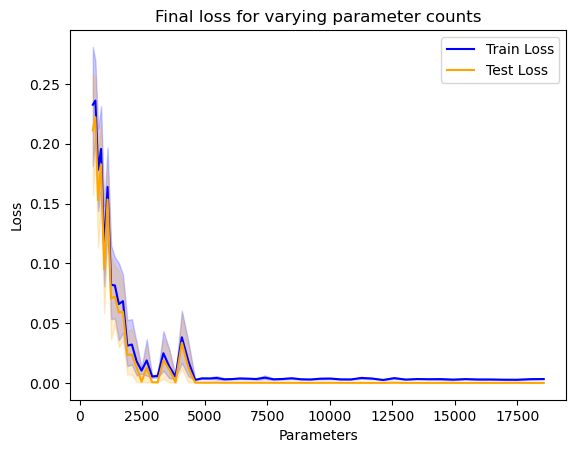

C:\Users\plogo\anaconda3\envs\cnn\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\plogo\anaconda3\envs\cnn\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\plogo\anaconda3\envs\cnn\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\plogo\anaconda3\envs\cnn\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Conver

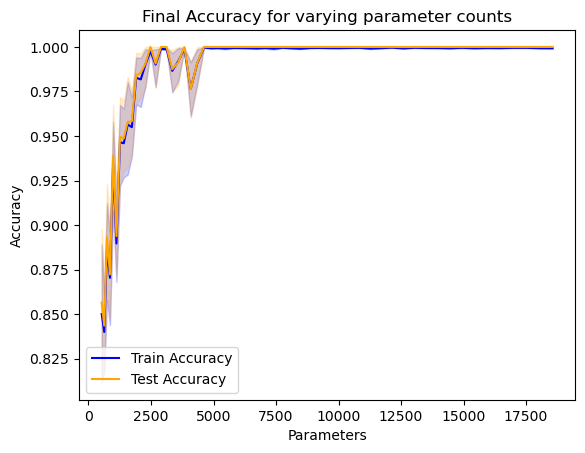

In [43]:
# INCLUDING REPEATS. Not including explicit display of graphs necessarily.

# hidden_size_list. Change the number of neurons in the hidden layer. Use n_tasks=6 and n_layers = 6 each time I think
# n_layers might be a bit too big, as I seemed to get pretty solid performance with n_layers = 4.

n_tasks = 6 # number of tasks created. must be less than or equal to 2^len_taskcode.
len_taskcode = 8 # length of the code defining the task. This will go at the beginning of each entry
num_checks = 3  # Length of the associated integer list for each task. Must be less than len_message
len_message = 12  # Maximum integer value in the associated integer list
num_samples = 10000 # number of samples created in the dataset
#samples_per_task = 1 # Kept at 1 for as long as I do not actually want to check the task performance
# Define hyperparameters
input_size = len_taskcode + len_message
output_size = 1
learning_rate = 0.005
batch_size = 32
num_epochs = 100
test_frac = 0.2
num_layers = 6
hidden_size_list = np.arange(8, 65, 1) #64 seems to be the smallest value which converges after about 100 epochs
num_repeats = 10

def generate_random_binary_string(length):
    binary_string = ''.join(secrets.choice(['0', '1']) for _ in range(length))
    return binary_string

def generate_dict(n_tasks, len_taskcode, num_checks, len_message):
    unique_strings = set()
    tasks_dict = {}

    while len(unique_strings) < n_tasks:
        binary_string = generate_random_binary_string(len_taskcode)

        if binary_string not in unique_strings:
            unique_strings.add(binary_string)

            integer_list = [secrets.randbelow(len_message) for _ in range(num_checks)]
            tasks_dict[binary_string] = integer_list

    return tasks_dict

def generate_dataset(tasks_dict, num_samples):
  data = np.zeros((num_samples, len_taskcode + len_message))
  value = np.zeros(num_samples)
  for i in range(num_samples):
    rand_task = np.random.choice(list(tasks_dict))
    rand_checkbits = tasks_dict[rand_task]
    message = generate_random_binary_string(len_message)
    parity_bit = 0
    for j in rand_checkbits:
      parity_bit += int(message[j])
    parity = parity_bit % 2
    data[i] = np.concatenate((np.array(list(rand_task)), np.array(list(message))))
    value[i] = parity
  return [data, value]

# Define a NN class WITH BATCH NORMALISATION
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, output_size, num_layers, hidden_size):
        super(NeuralNetwork, self).__init__()

        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(input_size, hidden_size))  # Additional linear layer
        
        for _ in range(num_layers - 2):
            self.layers.append(nn.Linear(hidden_size, hidden_size))
            self.layers.append(nn.BatchNorm1d(hidden_size))  # Add BatchNorm1d layer
        
        self.layers.append(nn.Linear(hidden_size, output_size))
    
    def forward(self, x):
        for i, layer in enumerate(self.layers[:-1]):
            if i == 0:  # Apply ReLU activation only after the additional linear layer
                x = F.relu(layer(x))
            else:
                x = layer(x)
                if i % 2 == 0:
                    x = F.relu(x)  # Apply ReLU activation after each linear layer
        x = self.layers[-1](x)
        return x

# Define a custom dataset
class CustomDataset(Dataset):
    def __init__(self, dataframe):
        self.data = dataframe.iloc[:, :-1].values
        self.target = dataframe.iloc[:, -1].values
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        x = torch.from_numpy(self.data[idx]).float()
        y = torch.tensor(self.target[idx]).float()
        return x, y
    
    
final_train_loss = np.empty((num_repeats, len(hidden_size_list)))
final_test_loss = np.empty((num_repeats, len(hidden_size_list)))
final_train_accuracy = np.empty((num_repeats, len(hidden_size_list)))
final_test_accuracy = np.empty((num_repeats, len(hidden_size_list)))
parameter_list = np.empty((num_repeats, len(hidden_size_list)))
    
#plt.close()
#fig, axs = plt.subplots(len(hidden_size_list), 2, figsize=(10, len(hidden_size_list)*5))
for repeat_idx in range(num_repeats):
    #print(f"Repeat: {repeat_idx}")

    for index, hidden_size in enumerate(hidden_size_list):
        
        tasks_dict = generate_dict(n_tasks, len_taskcode, num_checks, len_message)

        [data, value] = generate_dataset(tasks_dict, num_samples)

        # Create a dataframe for training
        df = pd.DataFrame(np.concatenate((data, value.reshape(-1, 1)), axis=1), columns=[f'feature_{i}' for i in range(len_taskcode + len_message)] + ['target'])

        # Split the data into training and test sets
        #train_df, test_df = train_test_split(df, test_size=test_frac, random_state=42)
        train_df, test_df = train_test_split(df, test_size=test_frac, random_state=42)

        # Create instances of the neural network
        model = NeuralNetwork(input_size, output_size, num_layers, hidden_size)

        # Define loss function and optimizer (same as before)
        criterion = nn.BCEWithLogitsLoss()
        optimizer = optim.SGD(model.parameters(), lr=learning_rate)

        # Create DataLoaders for the training and test data
        train_dataset = CustomDataset(train_df)
        test_dataset = CustomDataset(test_df)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

        #train_loss_list = np.empty(num_epochs)
        #test_loss_list = np.empty(num_epochs)

        #train_accuracy_list = np.empty(num_epochs)
        #test_accuracy_list = np.empty(num_epochs)

        #accuracy_array = np.zeros((n_tasks, num_epochs)) # such that each row is the accuracy for that specific task over all epochs

        # Train the model
        for epoch in tqdm(range(num_epochs), leave=False, desc=f'Repeat: {repeat_idx}, Hidden size: {hidden_size}'):
            train_loss = 0.0
            train_correct = 0
            train_total = 0
            model.train()

            for inputs, labels in train_loader:
                # Forward pass
                outputs = model(inputs)

                # Compute loss
                loss = criterion(outputs, labels.unsqueeze(1))

                # Compute predictions
                predictions = (outputs >= 0.5).squeeze().long()

                # Compute accuracy
                train_correct += (predictions == labels).sum().item()
                train_total += labels.size(0)

                # Backward pass and optimization
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                train_loss += loss.item() * inputs.size(0)

            # Calculate average train loss
            train_loss = train_loss / len(train_dataset)
            # Calculate average train accuracy
            train_accuracy = train_correct / train_total

            if epoch == num_epochs-1: #if this is the final epoch

                final_train_loss[repeat_idx, index] = train_loss
                final_train_accuracy[repeat_idx, index] = train_accuracy

                # Evaluate the model on the test set
                model.eval()
                test_loss = 0.0
                test_correct = 0
                test_total = 0

                with torch.no_grad():
                    for inputs, labels in test_loader:
                        outputs = model(inputs)
                        # Compute predictions
                        predictions = (outputs >= 0.5).squeeze().long()

                        # Compute accuracy
                        test_correct += (predictions == labels).sum().item()
                        test_total += labels.size(0)

                        loss = criterion(outputs, labels.unsqueeze(1))
                        test_loss += loss.item() * inputs.size(0)

                    # Calculate average test loss
                    test_loss = test_loss / len(test_dataset)

                # Calculate average test accuracy
                test_accuracy = test_correct / test_total

                final_test_loss[repeat_idx, index] = test_loss
                final_test_accuracy[repeat_idx, index] = test_accuracy

        pytorch_total_params = sum(p.numel() for p in model.parameters())
        parameter_list[repeat_idx, index] = pytorch_total_params
        
        #print(f"final_test_loss = {test_loss}, final_train_loss = {train_loss}, final_test_accuracy = {test_accuracy}, final_train_accuracy = {train_accuracy}")
        
# Create seaborn plots of loss
# Create DataFrames
train_loss_df = pd.DataFrame({'Parameters': parameter_list.flatten(), 'Train Loss': final_train_loss.flatten()})
test_loss_df = pd.DataFrame({'Parameters': parameter_list.flatten(), 'Test Loss': final_test_loss.flatten()})

# Concatenate DataFrames
combined_loss_df = pd.concat([train_loss_df, test_loss_df], axis=0)

# Plot the lineplot
sns.lineplot(data=combined_loss_df, x='Parameters', y='Train Loss', color='blue', label='Train Loss')
sns.lineplot(data=combined_loss_df, x='Parameters', y='Test Loss', color='orange', label='Test Loss')
plt.title('Final loss for varying parameter counts')
plt.xlabel('Parameters')
plt.ylabel('Loss')
plt.legend()
plt.show()

#Create seaborn plots of accuracy
train_accuracy_df = pd.DataFrame({'Parameters': parameter_list.flatten(), 'Train Accuracy': final_train_accuracy.flatten()})
test_accuracy_df = pd.DataFrame({'Parameters': parameter_list.flatten(), 'Test Accuracy': final_test_accuracy.flatten()})

# Concatenate DataFrames
combined_accuracy_df = pd.concat([train_accuracy_df, test_accuracy_df], axis=0)

# Plot the lineplot
sns.lineplot(data=combined_accuracy_df, x='Parameters', y='Train Accuracy', color='blue', label='Train Accuracy')
sns.lineplot(data=combined_accuracy_df, x='Parameters', y='Test Accuracy', color='orange', label='Test Accuracy')
plt.title('Final Accuracy for varying parameter counts')
plt.xlabel('Parameters')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

End of repeat 0. ETA = 13856.0s


End of repeat 1. ETA = 11724.1s


End of repeat 2. ETA = 11012.8s


End of repeat 3. ETA = 9261.2s


End of repeat 4. ETA = 7372.3s


End of repeat 5. ETA = 5879.5s


End of repeat 6. ETA = 4415.5s


End of repeat 7. ETA = 3238.4s


End of repeat 8. ETA = 1652.1s


End of repeat 9. ETA = 0.0s


C:\Users\plogo\anaconda3\envs\cnn\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\plogo\anaconda3\envs\cnn\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\plogo\anaconda3\envs\cnn\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\plogo\anaconda3\envs\cnn\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Conver

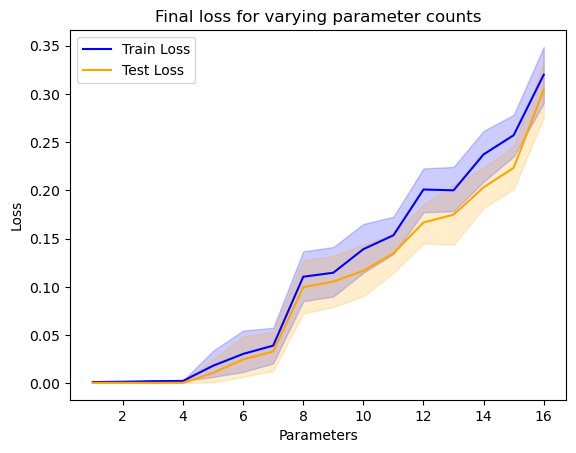

C:\Users\plogo\anaconda3\envs\cnn\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\plogo\anaconda3\envs\cnn\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\plogo\anaconda3\envs\cnn\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\plogo\anaconda3\envs\cnn\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Conver

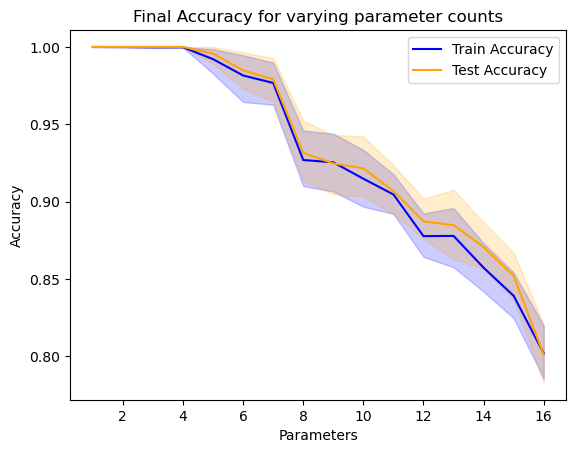

In [57]:
# Final values for varying number of samples. 
# The above data makes it look to me like the right number is around 2000 parameters (for good fit at 10,000 samples)
# Maybe later I should try 5000 parameters. Seems to be the magic perfect generalisation number?
# For ref, For hidden size = 32, parameter number = 5185 & For hidden size = 19, parameter number = 2091

# INCLUDING REPEATS. Not including explicit display of graphs necessarily.

# hidden_size_list. Change the number of neurons in the hidden layer. Use n_tasks=6 and n_layers = 6 each time I think
# n_layers might be a bit too big, as I seemed to get pretty solid performance with n_layers = 4.

n_tasks_list = np.arange(1, 17, 1) # number of tasks created. must be less than or equal to 2^len_taskcode.
len_taskcode = 8 # length of the code defining the task. This will go at the beginning of each entry
num_checks = 3  # Length of the associated integer list for each task. Must be less than len_message
len_message = 12  # Maximum integer value in the associated integer list
num_samples = 10000 # number of samples created in the dataset
#samples_per_task = 1 # Kept at 1 for as long as I do not actually want to check the task performance
# Define hyperparameters
input_size = len_taskcode + len_message
output_size = 1
learning_rate = 0.005
batch_size = 32
num_epochs = 100
test_frac = 0.2
num_layers = 6
hidden_size = 19 #64 seems to be the smallest value which converges after about 100 epochs
num_repeats = 10

import time

def generate_random_binary_string(length):
    binary_string = ''.join(secrets.choice(['0', '1']) for _ in range(length))
    return binary_string

def generate_dict(n_tasks, len_taskcode, num_checks, len_message):
    unique_strings = set()
    tasks_dict = {}

    while len(unique_strings) < n_tasks:
        binary_string = generate_random_binary_string(len_taskcode)

        if binary_string not in unique_strings:
            unique_strings.add(binary_string)

            integer_list = [secrets.randbelow(len_message) for _ in range(num_checks)]
            tasks_dict[binary_string] = integer_list

    return tasks_dict

def generate_dataset(tasks_dict, num_samples):
  data = np.zeros((num_samples, len_taskcode + len_message))
  value = np.zeros(num_samples)
  for i in range(num_samples):
    rand_task = np.random.choice(list(tasks_dict))
    rand_checkbits = tasks_dict[rand_task]
    message = generate_random_binary_string(len_message)
    parity_bit = 0
    for j in rand_checkbits:
      parity_bit += int(message[j])
    parity = parity_bit % 2
    data[i] = np.concatenate((np.array(list(rand_task)), np.array(list(message))))
    value[i] = parity
  return [data, value]

# Define a NN class WITH BATCH NORMALISATION
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, output_size, num_layers, hidden_size):
        super(NeuralNetwork, self).__init__()

        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(input_size, hidden_size))  # Additional linear layer
        
        for _ in range(num_layers - 2):
            self.layers.append(nn.Linear(hidden_size, hidden_size))
            self.layers.append(nn.BatchNorm1d(hidden_size))  # Add BatchNorm1d layer
        
        self.layers.append(nn.Linear(hidden_size, output_size))
    
    def forward(self, x):
        for i, layer in enumerate(self.layers[:-1]):
            if i == 0:  # Apply ReLU activation only after the additional linear layer
                x = F.relu(layer(x))
            else:
                x = layer(x)
                if i % 2 == 0:
                    x = F.relu(x)  # Apply ReLU activation after each linear layer
        x = self.layers[-1](x)
        return x

# Define a custom dataset
class CustomDataset(Dataset):
    def __init__(self, dataframe):
        self.data = dataframe.iloc[:, :-1].values
        self.target = dataframe.iloc[:, -1].values
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        x = torch.from_numpy(self.data[idx]).float()
        y = torch.tensor(self.target[idx]).float()
        return x, y
    
    
final_train_loss = np.empty((num_repeats, len(n_tasks_list)))
final_test_loss = np.empty((num_repeats, len(n_tasks_list)))
final_train_accuracy = np.empty((num_repeats, len(n_tasks_list)))
final_test_accuracy = np.empty((num_repeats, len(n_tasks_list)))
parameter_list = np.empty((num_repeats, len(n_tasks_list)))
    
#plt.close()
#fig, axs = plt.subplots(len(hidden_size_list), 2, figsize=(10, len(hidden_size_list)*5))
for repeat_idx in range(num_repeats):
    #print(f"Repeat: {repeat_idx}")
    start_i = time.time()

    for index, n_tasks in enumerate(n_tasks_list):
        
        tasks_dict = generate_dict(n_tasks, len_taskcode, num_checks, len_message)

        [data, value] = generate_dataset(tasks_dict, num_samples)

        # Create a dataframe for training
        df = pd.DataFrame(np.concatenate((data, value.reshape(-1, 1)), axis=1), columns=[f'feature_{i}' for i in range(len_taskcode + len_message)] + ['target'])

        # Split the data into training and test sets
        #train_df, test_df = train_test_split(df, test_size=test_frac, random_state=42)
        train_df, test_df = train_test_split(df, test_size=test_frac, random_state=42)

        # Create instances of the neural network
        model = NeuralNetwork(input_size, output_size, num_layers, hidden_size)

        # Define loss function and optimizer (same as before)
        criterion = nn.BCEWithLogitsLoss()
        optimizer = optim.SGD(model.parameters(), lr=learning_rate)

        # Create DataLoaders for the training and test data
        train_dataset = CustomDataset(train_df)
        test_dataset = CustomDataset(test_df)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

        #train_loss_list = np.empty(num_epochs)
        #test_loss_list = np.empty(num_epochs)

        #train_accuracy_list = np.empty(num_epochs)
        #test_accuracy_list = np.empty(num_epochs)

        #accuracy_array = np.zeros((n_tasks, num_epochs)) # such that each row is the accuracy for that specific task over all epochs

        # Train the model
        for epoch in tqdm(range(num_epochs), leave=False, desc=f'Repeat: {repeat_idx}, Number of Tasks: {n_tasks}'):
            train_loss = 0.0
            train_correct = 0
            train_total = 0
            model.train()

            for inputs, labels in train_loader:
                # Forward pass
                outputs = model(inputs)

                # Compute loss
                loss = criterion(outputs, labels.unsqueeze(1))

                # Compute predictions
                predictions = (outputs >= 0.5).squeeze().long()

                # Compute accuracy
                train_correct += (predictions == labels).sum().item()
                train_total += labels.size(0)

                # Backward pass and optimization
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                train_loss += loss.item() * inputs.size(0)

            # Calculate average train loss
            train_loss = train_loss / len(train_dataset)
            # Calculate average train accuracy
            train_accuracy = train_correct / train_total

            if epoch == num_epochs-1: #if this is the final epoch

                final_train_loss[repeat_idx, index] = train_loss
                final_train_accuracy[repeat_idx, index] = train_accuracy

                # Evaluate the model on the test set
                model.eval()
                test_loss = 0.0
                test_correct = 0
                test_total = 0

                with torch.no_grad():
                    for inputs, labels in test_loader:
                        outputs = model(inputs)
                        # Compute predictions
                        predictions = (outputs >= 0.5).squeeze().long()

                        # Compute accuracy
                        test_correct += (predictions == labels).sum().item()
                        test_total += labels.size(0)

                        loss = criterion(outputs, labels.unsqueeze(1))
                        test_loss += loss.item() * inputs.size(0)

                    # Calculate average test loss
                    test_loss = test_loss / len(test_dataset)

                # Calculate average test accuracy
                test_accuracy = test_correct / test_total

                final_test_loss[repeat_idx, index] = test_loss
                final_test_accuracy[repeat_idx, index] = test_accuracy

        #pytorch_total_params = sum(p.numel() for p in model.parameters())
        parameter_list[repeat_idx, index] = n_tasks
        
        #print(f"final_test_loss = {test_loss}, final_train_loss = {train_loss}, final_test_accuracy = {test_accuracy}, final_train_accuracy = {train_accuracy}")
    try:
        end_i = time.time()
        time_elapsed = end_i - start_i
        ETA = (num_repeats-(repeat_idx+1)) * time_elapsed
        print(f'End of repeat {repeat_idx}. ETA = {ETA:.1f}s')
    except:
        print("Error with ETA calculation")
        
# Create seaborn plots of loss
# Create DataFrames
train_loss_df = pd.DataFrame({'Parameters': parameter_list.flatten(), 'Train Loss': final_train_loss.flatten()})
test_loss_df = pd.DataFrame({'Parameters': parameter_list.flatten(), 'Test Loss': final_test_loss.flatten()})

# Concatenate DataFrames
combined_loss_df = pd.concat([train_loss_df, test_loss_df], axis=0)

# Plot the lineplot
sns.lineplot(data=combined_loss_df, x='Parameters', y='Train Loss', color='blue', label='Train Loss')
sns.lineplot(data=combined_loss_df, x='Parameters', y='Test Loss', color='orange', label='Test Loss')
plt.title('Final loss for varying parameter counts')
plt.xlabel('Parameters')
plt.ylabel('Loss')
plt.legend()
plt.show()

#Create seaborn plots of accuracy
train_accuracy_df = pd.DataFrame({'Parameters': parameter_list.flatten(), 'Train Accuracy': final_train_accuracy.flatten()})
test_accuracy_df = pd.DataFrame({'Parameters': parameter_list.flatten(), 'Test Accuracy': final_test_accuracy.flatten()})

# Concatenate DataFrames
combined_accuracy_df = pd.concat([train_accuracy_df, test_accuracy_df], axis=0)

# Plot the lineplot
sns.lineplot(data=combined_accuracy_df, x='Parameters', y='Train Accuracy', color='blue', label='Train Accuracy')
sns.lineplot(data=combined_accuracy_df, x='Parameters', y='Test Accuracy', color='orange', label='Test Accuracy')
plt.title('Final Accuracy for varying parameter counts')
plt.xlabel('Parameters')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

C:\Users\plogo\anaconda3\envs\cnn\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\plogo\anaconda3\envs\cnn\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\plogo\anaconda3\envs\cnn\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\plogo\anaconda3\envs\cnn\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Conver

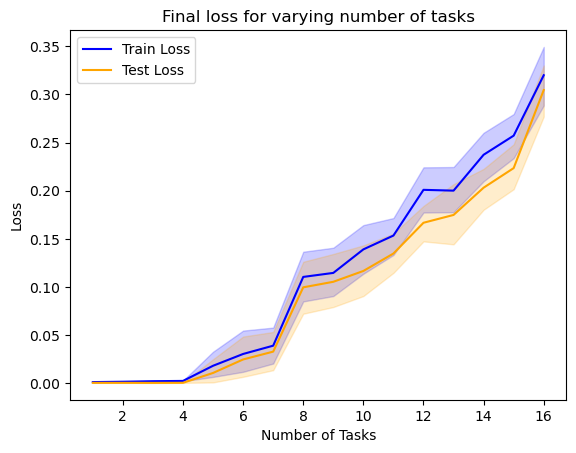

C:\Users\plogo\anaconda3\envs\cnn\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\plogo\anaconda3\envs\cnn\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\plogo\anaconda3\envs\cnn\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\plogo\anaconda3\envs\cnn\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Conver

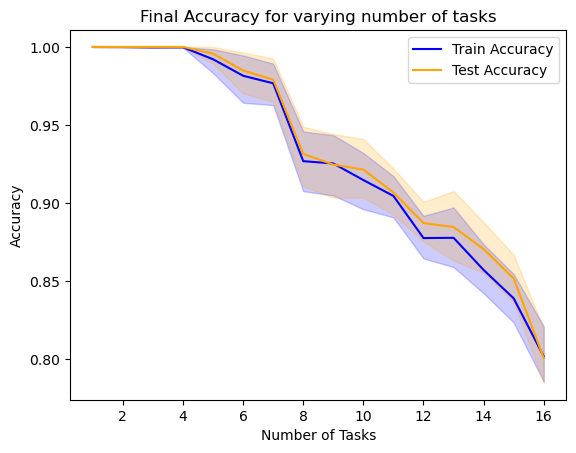

In [59]:
# Create seaborn plots of loss
# Create DataFrames
train_loss_df = pd.DataFrame({'Parameters': parameter_list.flatten(), 'Train Loss': final_train_loss.flatten()})
test_loss_df = pd.DataFrame({'Parameters': parameter_list.flatten(), 'Test Loss': final_test_loss.flatten()})

# Concatenate DataFrames
combined_loss_df = pd.concat([train_loss_df, test_loss_df], axis=0)

# Plot the lineplot
sns.lineplot(data=combined_loss_df, x='Parameters', y='Train Loss', color='blue', label='Train Loss')
sns.lineplot(data=combined_loss_df, x='Parameters', y='Test Loss', color='orange', label='Test Loss')
plt.title('Final loss for varying number of tasks')
plt.xlabel('Number of Tasks')
plt.ylabel('Loss')
plt.legend()
plt.show()

#Create seaborn plots of accuracy
train_accuracy_df = pd.DataFrame({'Parameters': parameter_list.flatten(), 'Train Accuracy': final_train_accuracy.flatten()})
test_accuracy_df = pd.DataFrame({'Parameters': parameter_list.flatten(), 'Test Accuracy': final_test_accuracy.flatten()})

# Concatenate DataFrames
combined_accuracy_df = pd.concat([train_accuracy_df, test_accuracy_df], axis=0)

# Plot the lineplot
sns.lineplot(data=combined_accuracy_df, x='Parameters', y='Train Accuracy', color='blue', label='Train Accuracy')
sns.lineplot(data=combined_accuracy_df, x='Parameters', y='Test Accuracy', color='orange', label='Test Accuracy')
plt.title('Final Accuracy for varying number of tasks')
plt.xlabel('Number of Tasks')
plt.ylabel('Accuracy')
plt.legend()
plt.show()